# Load packages and use tensorflow as backend

In [4]:
######################################################
# Install a pip package in the current Jupyter kernel
# import system level packages
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install requests
#import requests
######################################################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
from keras import utils
import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
#from .tqdm_callback import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.python.client import device_lib

########################################################
#importing necessary libraries for scikit-learn

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #!!!the grid search package that has issue, dont use it
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from scipy import interp
from scipy import stats

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

In [5]:
##################################################
#test tensorflow, remember to change the kernel
#using kernel that supports GPU computing
#simple test to confirm tensorflow is actually working
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))
a = tf.constant(10)
b = tf.constant(32)
print("10 + 32 = ", sess.run(a + b))
#manually set the random seed to define a replication
r_seed = 42

#manually set the number for cross validation
num_cv = 5

print("current random seed is: ", r_seed)

b'Hello, TensorFlow!'
10 + 32 =  42
current random seed is:  42


# check the system information

In [6]:
#######################################################################################################
#check the system information, check if cuda and gpu computing for tensorflow is installed properly
#######################################################################################################
print("whether tensorflow is built with cuda: ", tf.test.is_built_with_cuda())
print("whether gpu computing is available for tensorflow: ", tf.test.is_gpu_available())
print("using keras version: ", keras.__version__)
print("using tensorflow version: ", tf.__version__)
print("using python version: ", sys.version)

print("\n")
print("Device details:\n", device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

whether tensorflow is built with cuda:  True
whether gpu computing is available for tensorflow:  True
using keras version:  2.1.3
using tensorflow version:  1.4.1
using python version:  3.5.5 | packaged by conda-forge | (default, Apr  6 2018, 13:41:05) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


Device details:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16527836662570456973
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 234422272
locality {
  bus_id: 1
}
incarnation: 16660977068660328228
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Default GPU Device: /device:GPU:0


# Reading files

In [7]:
##########################################################
# Reading files/documents                                #
# !!! Need to change to file location on your local drive#
##########################################################

#vae file
compress_path = 'counts_data/vae_compressed_wLabels/encoded_BRCA_rnaseq_vae_binaryLabels(L2,perSp,a1.0,unlabel,0.2_var,10LF3kX4,z100,minmax,ep700).txt'

#vae with grade file
#compress_path = 'counts_data/vae_compressed_with_grade/TCGA_4cancers_(BLCA_perSP_minmax_3labels_6LF6k_z200)_with_grade.txt'
# vae with stage file
#compress_path = 'counts_data/vae_compressed_with_stage/TCGA_4cancers_(PAAD_perSP_minmax_3labels_6LF6k_z50)_with_stage.txt'


#open(path).readline()
#gene expression RNAseq, Batch effects normalized mRNA data

og_data = pd.read_csv(compress_path, sep = "\t", index_col = 0)
og_data = og_data.dropna(axis='columns')
#ExprAlldata.columns = ["Gene", "Counts"]
print("dimension of the input data: ", og_data.shape)
og_data.head(5)

dimension of the input data:  (394, 102)


,Ensembl_ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,response_group
64,TCGA-3C-AAAU-01A,1.088473,2.424567,0.157463,-0.404247,1.061271,0.143493,0.105334,0.342563,0.162095,...,0.832970,-0.464828,0.574068,1.741562,0.265233,-1.127761,-0.125910,0.201530,-1.550137,1
65,TCGA-3C-AALI-01A,0.215533,1.076739,-0.481294,0.649808,0.076814,1.126920,-0.105212,0.364895,-1.968343,...,-0.000380,0.216843,0.927196,0.103062,-0.019731,-0.003636,0.419202,0.885741,0.048102,0
66,TCGA-3C-AALJ-01A,0.508701,0.747061,-1.640794,-1.958025,0.004146,-0.540467,-0.827739,-0.917648,0.343937,...,0.490097,0.235427,0.204383,0.728351,1.849964,-1.685548,-0.480700,0.048835,0.206371,0
67,TCGA-3C-AALK-01A,1.208645,0.995264,1.136929,2.012560,1.375656,0.038891,-0.211389,-0.514640,-0.670969,...,0.447790,0.418877,-0.620410,-1.159467,0.278549,-1.965660,0.712284,-1.221580,-1.788221,0
72,TCGA-4H-AAAK-01A,-2.805437,0.147663,-0.138205,-0.569776,0.304589,0.386833,1.932113,-0.613983,1.600362,...,-0.063452,-1.984807,-0.406423,-0.342070,0.552063,0.183707,0.075095,-0.285216,-0.308866,0


## Number of cases in each category

In [8]:
df_count = og_data.groupby('response_group')['Ensembl_ID'].nunique()
print(df_count)
#df_count.nlargest(10)

response_group
0    353
1     41
Name: Ensembl_ID, dtype: int64


In [9]:
###################################################
#store the raw data, and use ensembl id as index
##################################################
df_raw = og_data.iloc[:, 0:]
df_raw = df_raw.set_index('Ensembl_ID')

#notice the last column is the response_group
#df_raw.shape
df_raw.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,response_group
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A,1.088473,2.424567,0.157463,-0.404247,1.061271,0.143493,0.105334,0.342563,0.162095,-1.385175,...,0.832970,-0.464828,0.574068,1.741562,0.265233,-1.127761,-0.125910,0.201530,-1.550137,1
TCGA-3C-AALI-01A,0.215533,1.076739,-0.481294,0.649808,0.076814,1.126920,-0.105212,0.364895,-1.968343,0.415002,...,-0.000380,0.216843,0.927196,0.103062,-0.019731,-0.003636,0.419202,0.885741,0.048102,0
TCGA-3C-AALJ-01A,0.508701,0.747061,-1.640794,-1.958025,0.004146,-0.540467,-0.827739,-0.917648,0.343937,-0.751112,...,0.490097,0.235427,0.204383,0.728351,1.849964,-1.685548,-0.480700,0.048835,0.206371,0


In [10]:
#####################################!#################################
#here begins full data
################################
#full data, 4 labels analysis
#Complete Response    21
#Clinical Progressive Disease    10
#Radiographic Progressive Disease     7
#Stable Disease     7

#features
df_raw_coln = len(df_raw.columns)
X = df_raw.iloc[:,0:(df_raw_coln-1)]
X = X.values

#label/target
y = df_raw.loc[:, 'response_group']
y = y.values

#!!!!!!!
#check to confirm the last column is not response group, only y contains response group information
col = X.shape[1]
#print(X[:,(col-1)])

class_names = np.unique(y)
print("unique labels from y: ", class_names)

unique labels from y:  [0 1]


# Load necessary methods

In [11]:
#########################################################################################
#plot confusion matrix
#inputs: cm, confusion matrix from cross_val_predict
#        normalize, whether to use normalize for each sections 
#        title, input the title name for the figure
#        cmap, color map using blue as default
#output: a confusion matrix plot with true label as y axis, and predicted label as x axis
#########################################################################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
##############################################################
#plot area under curve graph
#input: actual, true labels/target without one hot encoding
#       probs, predicted probabilities
#       n_classes, number of unique classes in target
#       title, input the title name for the figure
#output: a roc curve plot for multi class task
###############################################################
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

def plot_multiclass_roc_auc(actual, probs, n_classes, title = 'multi-class roc'):
    lb = LabelBinarizer()
    lb.fit(actual)
    actual = lb.transform(actual)
    y_prob = probs
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual[:, i], y_prob[:, i])
        #please notice the difference between auc() and roc_auc_score()
        #also auc() only works on monotonic increasing or monotonic
        #decreasing input x
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
        label='ROC curve of class {0} (area = {1:0.10f})'
            ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data using '+title)
    plt.legend(loc="lower right")
    #commented thus being able to use fig save function
    #plt.show()

In [13]:
#######################################################
#Random search CV method
#and
#Multi class roc_auc score method
########################################################
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer, roc_auc_score

###########################################################################################
#Multi class roc_auc score method
#input: y_test, true labels from test fold
#       y_prob, predicted probability on test fold
#       average, string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
#                'macro': Calculate metrics for each label, and find their unweighted mean. 
#                This does not take label imbalance into account.
#                'weighted': Calculate metrics for each label, and find their average, 
#                weighted by support (the number of true instances for each label).
#output: auroc value for each class
#multiclass_score, an implemented scoring method for multi class task
#!!!
#Notice that by default,needs_proba : boolean, default=False
#thus the multiclass_score will try to use the predicted label instead of predicted probability to calculate roc
#which is not correct, and will causing the tuning process to not find the best parameters
##############################################################################################
def multiclass_roc_auc_score(y_test, y_prob, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    #y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_prob, average=average)

#!!!
#Notice that by default,needs_proba : boolean, default=False
#thus the multiclass_score will try to use the predicted label instead of predicted probability to calculate roc
#which is not correct, and will causing the tuning process to not find the best parameters
multiclass_score = make_scorer(multiclass_roc_auc_score, needs_proba = True)

###############################################################################################
#Binary class roc auc score method
#input: y_true, true labels from test fold
#       y_score, predicted probability on test fold
#       average, string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
#                'macro': Calculate metrics for each label, and find their unweighted mean. 
#                This does not take label imbalance into account.
#                'weighted': Calculate metrics for each label, and find their average, 
#                weighted by support (the number of true instances for each label).
#output: auroc value for each class
#############################################################################################
def binary_class_roc_auc_score(y_true, y_score, average="weighted"):

    return roc_auc_score(y_true, y_score, average=average)

binaryclass_score = make_scorer(binary_class_roc_auc_score, needs_threshold = True)

###################################################################################
#Random search CV method
#input: est, input estimator/classifier
#       p_distr, the grid of parameters to search on
#       nbr_iter, numbers of iteration on random search
#       X, feature, y, true labels
#output: ht_estimator, best estimator based on mean value of all folds
#        ht_params, best parameters
#
################################################################################################
def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    #seed = 42
    cv = StratifiedKFold(n_splits = 3, random_state = r_seed, shuffle = True)
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr, scoring=multiclass_score,
                                  n_jobs=-1, n_iter=nbr_iter, cv=cv, return_train_score = True, verbose =10)
    #CV = Cross-Validation ( here using Stratified KFold CV) #,random_state = seed
    start = time()
    rdmsearch.fit(X,y)
    print('hyper-tuning time : %d seconds' % (time()-start))
    start = 0
   # ht_train_mean = rdmsearch.cv_results_['mean_train_score']
   # ht_train_std = rdmsearch.cv_results_['std_train_score']
   # ht_test_mean_sp0 = rdmsearch.cv_results_['split0_test_score']
   # ht_test_mean_sp1 = rdmsearch.cv_results_['split1_test_score']
   # ht_test_mean_sp2 = rdmsearch.cv_results_['split2_test_score']
    #ht_train_mean_sp3 = rdmsearch.cv_results_['split3_train_score']
    #ht_train_mean_sp4 = rdmsearch.cv_results_['split4_train_score']
    #ht_best_loc = np.where(rdmsearch.cv_results_['rank_test_score'] == 1)
    
    ht_cv_results = rdmsearch.cv_results_
    ht_estimator = rdmsearch.best_estimator_
    ht_params = rdmsearch.best_params_
    #ht_score = rdmsearch.best_score_
    
    return ht_estimator, ht_params, ht_cv_results

# Grid search

In [14]:
###########################################################
#Grid search Tune learning rate, n_estimators, and booster
#
##########################################################
param_test_this_loop = {
 'learning_rate':[0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
 'n_estimators':[i for i in range(1,40)],
 'booster':['gbtree'],
 #'booster':['gbtree','gblinear','dart'],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop1 = GridSearchCV(estimator = XGBClassifier(booster = 'gbtree'), 
 param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop1.fit(X,y)
gsearch_loop1.grid_scores_, gsearch_loop1.best_params_, gsearch_loop1.best_score_

Fitting 5 folds for each of 234 candidates, totalling 1170 fits
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.4857142857142857, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.5089285714285714

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0242s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=8, booster=gbtree, score=0.494718309859155, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=8, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=20, booster=gbtree, score=0.3424295774647887, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.35475352112676056, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=23, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=20, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=11, booster=gbtree, score=0.36619718309859156, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=11, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=8, booster=gbtree, score=0.36619718309859156, total=   0.0s
[CV]

[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=21, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.4107142857142857, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=15, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.4702660406885759, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=27, booster=gbtree, score=0.4084507042253521, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=27, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.34285714285714286, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=18, booster=gbtree, score=0.4538341158059468, total=   0.0s
[CV] 

[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=28, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=19, booster=gbtree, score=0.45383411580594674, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=19, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=25, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=13, booster=gbtree, score=0.36619718309859156, total=   0.0s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.40923317683881066, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=16, booster=gbtree, score=0.38028169014084506, total=   0.0s
[CV] learning_rate=0.05, random_state=42

[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.6044642857142858, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=34, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=3, booster=gbtree, score=0.41428571428571426, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=28, booster=gbtree, score=0.5455357142857142, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=29, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=3, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=3, booster=gbtree, score=0.46785714285714286, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=4, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.38116197183098594, total=   0.1s
[CV] lea

[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=31, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=2, booster=gbtree, score=0.5391236306729265, total=   0.0s
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=8, booster=gbtree, score=0.40219092331768386, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=8, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.3380281690140845, total=   0.1s
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=5, booster=gbtree, score=0.4080357142857143, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=37, booster=gbtree, score=0.4045383411580595, total=   0.1s
[CV] learning_

[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=11, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=16, booster=gbtree, score=0.39732142857142855, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=9, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=16, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.301056338028169, total=   0.0s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=34, booster=gbtree, score=0.5973214285714286, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=35, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.42801251956181535, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=Tr

[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.5s


[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=17, booster=gbtree, score=0.3724569640062597, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=22, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=20, booster=gbtree, score=0.36932707355242567, total=   0.1s
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=11, booster=gbtree, score=0.4017857142857143, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=11, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=20, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.37167449139280123, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=14, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=Tr

[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=21, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=18, booster=gbtree 
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=38, booster=gbtree, score=0.3943661971830986, total=   0.1s
[CV]  learning_rate=0.05, random_state=42, silent=True, n_estimators=35, booster=gbtree, score=0.6053571428571428, total=   0.1s
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.4598214285714286, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=23, booster=gbtree 
[CV] learning_rate=0.05, random_state=42, silent=True, n_estimators=36, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=12, booster=gbtree, score=0.5571428571428572, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=T

[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=22, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=24, booster=gbtree, score=0.43221830985915494, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=24, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=19, booster=gbtree, score=0.39348591549295775, total=   0.1s
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.48749999999999993, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.5107142857142857, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=27, booster=gbtree, score=0.3458528951486698, total=   0.1s
[CV] lear

[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=30, booster=gbtree, score=0.4454225352112676, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=30, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=5, booster=gbtree, score=0.4381846635367761, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=5, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=25, booster=gbtree, score=0.4348591549295775, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=6, booster=gbtree, score=0.4705357142857143, total=   0.0s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=25, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=27, booster=gbtree, score=0.48928571428571427, total=   0.1s
[CV] learning_r

[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.6s


[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=25, booster=gbtree, score=0.40845070422535207, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=5, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=25, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.3389084507042253, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=28, booster=gbtree, score=0.3599374021909233, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=5, booster=gbtree, score=0.5026785714285714, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=6, booster=gbtree 
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=28, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_

[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.5109546165884195, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=8, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=10, booster=gbtree, score=0.5089285714285715, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=10, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=13, booster=gbtree, score=0.43661971830985924, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=31, booster=gbtree, score=0.44718309859154937, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, 

[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=35, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.4454225352112676, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=14, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=11, booster=gbtree, score=0.6107142857142858, total=   0.0s
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.37089201877934275, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=32, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=12, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=19, booster=gbtree, score=0.4507042253521127, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=19, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=Tru

[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=28, booster=gbtree, score=0.5125, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=29, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.39906103286384975, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=23, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=15, booster=gbtree, score=0.5678571428571428, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.4397496087636933, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=35, booster=gbtree 
[CV]  learning_rate=0.1, random_state=42, silent=True, n_estimators=38, booster=gbtree, score=0.3732394366197183, total=   0.1s
[CV] learning_rate=0.1, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV] learning_rate=0.2,

[Parallel(n_jobs=-1)]: Batch computation too slow (2.0561s.) Setting batch_size=8.


[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=20, booster=gbtree, score=0.45774647887323944, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.4475743348982786, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=29, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=20, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.3556338028169014, total=   0.1s
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=17, booster=gbtree, score=0.5160714285714285, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=23, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=26, booster=gbtree, score=0.3732394366197183, total=   0.1s
[CV] learni

[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.49464285714285716, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=21, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=38, booster=gbtree, score=0.5123239436619718, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=18, booster=gbtree, score=0.47678571428571426, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=2, booster=gbtree, score=0.4154929577464789, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True,

[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    4.2s


[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=6, booster=gbtree, score=0.5203442879499217, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=6, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=4, booster=gbtree, score=0.442781690140845, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=4, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=39, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.43838028169014087, total=   0.1s
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=4, booster=gbtree, score=0.29225352112676056, total=   0.0s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=6, booster=gbtree, score=0.4595070422535212, total=   0.0s
[CV] learning_rat

[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=9, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=34, booster=gbtree, score=0.4585289514866979, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=34, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=15, booster=gbtree, score=0.5246478873239436, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=15, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=12, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.5285714285714286, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV]  learning_rate=0.2, random_state=42, silent=True, n_estimators=31, booster=gbtree, score=0.3573943661971831, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_

[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=16, booster=gbtree 
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=34, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=13, booster=gbtree, score=0.6571428571428571, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=11, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.4507042253521127, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=16, booster=gbtree, score=0.5303571428571429, total=   0.1s
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.47183098591549294, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n

[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=22, booster=gbtree, score=0.5086071987480438, total=   0.1s
[CV] learning_rate=0.2, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.6392857142857143, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=22, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.5946428571428571, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=23, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=14, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=20, booster=gbtree, score=0.6339285714285714, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True,

[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    5.3s


[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.5732142857142857, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=30, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=28, booster=gbtree, score=0.5616197183098591, total=   0.1s
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=25, booster=gbtree, score=0.5928571428571429, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=28, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=26, booster=gbtree, score=0.5678571428571428, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=27, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=25, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=24, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True

[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.5669014084507042, total=   0.1s
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.5642857142857143, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=36, booster=gbtree, score=0.545774647887324, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.5089285714285714, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=37, booster=gbtree, score=0.5714285714285714, total=   0.1s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=38, booster=gbtree 
[CV] learning_ra

[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=9, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=5, booster=gbtree, score=0.3829225352112676, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=5, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.46785714285714286, total=   0.0s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.45774647887323944, total=   0.0s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=8, booster=gbtree, score=0.45598591549295775, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=10, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=8, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_e

[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    6.2s


[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.38028169014084506, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=9, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.47183098591549294, total=   0.0s
[CV]  learning_rate=0.4, random_state=42, silent=True, n_estimators=38, booster=gbtree, score=0.5696428571428571, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=11, booster=gbtree, score=0.4735915492957747, total=   0.0s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=10, booster=gbtree, score=0.5571428571428572, total=   0.0s
[CV] learning_rate=0.4, random_state=42, silent=True, n_estimators=39, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=10, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_

[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.4242957746478873, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=14, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=15, booster=gbtree, score=0.47887323943661964, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=15, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=18, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=22, booster=gbtree, score=0.5874999999999999, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=12, booster=gbtree, score=0.5875, total=   0.0s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=19, booster=gbtree, score=0.5035714285714286, total=   0.0s
[CV] learning_rate=0.6,

[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=20, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=27, booster=gbtree, score=0.5589285714285714, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=24, booster=gbtree, score=0.5625, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=24, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=27, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=19, booster=gbtree, score=0.43309859154929575, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=22, booster=gbtree, score=0.42077464788732394, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=22, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=23, booster=gbtree, score=0.5767857142857142, total=   0.0s
[CV] learning_rate=0.6

[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    6.8s


[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=29, booster=gbtree, score=0.48767605633802813, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.47535211267605637, total=   0.1s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=28, booster=gbtree, score=0.539906103286385, total=   0.0s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=32, booster=gbtree 
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=29, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=25, booster=gbtree, score=0.5273865414710486, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=25, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=24, booster=gbtree, score=0.5352112676056338, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=28, booster=gbtree 
[CV] learni

[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=30, booster=gbtree, score=0.4841549295774648, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=2, booster=gbtree 
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=31, booster=gbtree, score=0.5375, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=31, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=1, booster=gbtree, score=0.47183098591549294, total=   0.0s
[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.471830985915493, total=   0.1s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=2, booster=gbtree, score=0.41785714285714287, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=1, booster=gbtree 
[CV]  learning_rate=0.6, ran

[CV]  learning_rate=0.6, random_state=42, silent=True, n_estimators=39, booster=gbtree, score=0.5195618153364633, total=   0.1s
[CV] learning_rate=0.6, random_state=42, silent=True, n_estimators=39, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.44285714285714284, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=7, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=10, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=5, booster=gbtree, score=0.4515845070422535, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=5, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=6, booster=gbtree, score=0.5352112676056338, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.5193661971830986, total=   0.0s
[CV]  learning_ra

[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=7, booster=gbtree, score=0.4454225352112676, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=12, booster=gbtree, score=0.5803571428571429, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=15, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=9, booster=gbtree, score=0.6431924882629108, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=11, booster=gbtree, score=0.5482142857142858, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.48415492957746475, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=12, booster=gbtree 
[CV] learning

[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:    7.6s


[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=17, booster=gbtree, score=0.44190140845070425, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=12, booster=gbtree, score=0.49295774647887325, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=13, booster=gbtree, score=0.45070422535211263, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=20, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=18, booster=gbtree, score=0.5589285714285714, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=19, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=13, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=14, booster=gbtree, score=0.5821428571428571, total=   0.0s
[CV] lear

[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=24, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=21, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=16, booster=gbtree, score=0.5410714285714285, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=17, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=18, booster=gbtree, score=0.47535211267605637, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=22, booster=gbtree, score=0.5053571428571428, total=   0.1s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=27, booster=gbtree, score=0.5336463223787167, total=   0.0s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=22, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=27, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=Tru

[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=28, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=30, booster=gbtree, score=0.49823943661971826, total=   0.1s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=31, booster=gbtree, score=0.5249999999999999, total=   0.1s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=33, booster=gbtree, score=0.4982394366197183, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=30, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=32, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=34, booster=gbtree, score=0.5428571428571428, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=35, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=Tru

[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=32, booster=gbtree, score=0.5375, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=35, booster=gbtree, score=0.5446428571428571, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=33, booster=gbtree 
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=36, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=31, booster=gbtree, score=0.49295774647887325, total=   0.0s
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=37, booster=gbtree, score=0.4964788732394366, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=37, booster=gbtree 
[CV]  learning_rate=0.8, random_state=42, silent=True, n_estimators=38, booster=gbtree, score=0.5660714285714286, total=   0.1s
[CV] learning_rate=0.8, random_state=42, silent=True, n_estimators=39, booster=gbtree 
[CV]  learning_rate=0.8

[Parallel(n_jobs=-1)]: Done 1170 out of 1170 | elapsed:    8.9s finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.48563, std: 0.02278, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 1, 'booster': 'gbtree'},
  mean: 0.46141, std: 0.04218, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 2, 'booster': 'gbtree'},
  mean: 0.46485, std: 0.04716, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 3, 'booster': 'gbtree'},
  mean: 0.45671, std: 0.05025, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 4, 'booster': 'gbtree'},
  mean: 0.44268, std: 0.05103, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 5, 'booster': 'gbtree'},
  mean: 0.43482, std: 0.03647, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 6, 'booster': 'gbtree'},
  mean: 0.42140, std: 0.03325, params: {'learning_rate': 0.05, 'random_state': 42, 'silent': True, 'n_estimators': 7, 'booster': 'gbtree'},
  mean: 0.43043, std

In [15]:
##########################################################
#output grid scores, and save to a file
#
#xgb_grid_scores = pd.DataFrame(gsearch1.grid_scores_)
#xgb_grid_file = os.path.join("Tuning_insights", "xgb_grid_socres(lr&n_estimators).tsv")
#xgb_grid_scores.to_csv(xgb_grid_file, sep='\t')

# Test to make sure the parameters are correct
#gsearch_loop1.best_params_
#gsearch_loop1.best_params_["learning_rate"]
#gsearch_loop1.best_params_["booster"]
#gsearch_loop1.best_params_["n_estimators"]

In [16]:
#################################################
#Grid search Tune max_depth and min_child_weight
#default
#################################################
param_test_this_loop = {
 'max_depth':[i for i in range(1,10)],
 'min_child_weight':[i for i in range(0,10)],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                  n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                  booster = gsearch_loop1.best_params_["booster"]), 
param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop2 .fit(X,y)
gsearch_loop2 .grid_scores_, gsearch_loop2 .best_params_, gsearch_loop2 .best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=1 ...
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=0, score=0.46635367762128327, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=1, score=0.31338028169014087, total=   0.0s
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=1 ...
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=0, score=0.3371478873239437, total=   0.0s
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=1 ...
[CV] random_state=42, silent=True, max_de

[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=7, score=0.5246478873239436, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=7, score=0.4830357142857143, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=0, score=0.5305164319248826, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=2, score=0.5339285714285714, total=   0.0s
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=7 ...
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=4, score=0.6196428571428572, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=0, score=0.5461658841940532, total=   0.1s
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weight=3 ...
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=7 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weig

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0267s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=2, score=0.4454225352112676, total=   0.0s
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=2 ...
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=4, score=0.36875, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=7, score=0.3946428571428572, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=0, score=0.29577464788732394, total=   0.0s
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=4 ...
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=3, score=0.45539906103286387, total=   0.0s
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=7 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weight=3 ...
[CV]  random_state=42, silent=True, max_depth=1, min_child_weight=7, score=0.36875, total=   0.0s
[CV] random_state=42, silent=True, max_depth=1, min_child_weight=8 ...
[CV]  rando

[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=0, score=0.5071428571428571, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=3, score=0.6461267605633803, total=   0.0s
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=3 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weight=1 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weight=8 ...
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=8 ...
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=5, score=0.5232142857142856, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=1, score=0.3741197183098592, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=2, min_child_weight=6, score=0.5211267605633803, total=   0.0s
[CV] random_state=42, silent=True, max_depth=2, min_child_weight=6 ...
[CV] random_state=42, silent=True, max_depth=3, min_child_weight=5 ...
[CV] random_state=42, silent=

[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=1, score=0.5803571428571429, total=   0.0s
[CV] random_state=42, silent=True, max_depth=4, min_child_weight=1 ...
[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=7, score=0.39280125195618154, total=   0.0s
[CV] random_state=42, silent=True, max_depth=4, min_child_weight=7 ...
[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=4, score=0.4806338028169014, total=   0.0s
[CV] random_state=42, silent=True, max_depth=4, min_child_weight=4 ...
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=1, score=0.5892857142857143, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=9, score=0.4839285714285715, total=   0.0s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=0 ...
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=5, score=0.4823943661971831, total=   0.0s
[CV] random_state=42, silent=True, max_depth=3, min_child_wei

[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=8, score=0.34507042253521125, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=0, score=0.41964285714285715, total=   0.1s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=5 ...
[CV] random_state=42, silent=True, max_depth=4, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=4, min_child_weight=8 ...
[CV]  random_state=42, silent=True, max_depth=3, min_child_weight=8, score=0.4102112676056338, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=3, score=0.3204225352112676, total=   0.1s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=8 ...
[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=5, score=0.5053571428571428, total=   0.0s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=3 ...
[CV]  random_state=42, sile

[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    0.9s


[CV] random_state=42, silent=True, max_depth=5, min_child_weight=4 ...
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=6, score=0.27816901408450706, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=6, min_child_weight=1, score=0.4303599374021909, total=   0.0s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=6 ...
[CV] random_state=42, silent=True, max_depth=6, min_child_weight=1 ...
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=8, score=0.45, total=   0.0s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=9 ...
[CV]  random_state=42, silent=True, max_depth=6, min_child_weight=6, score=0.494718309859155, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=6, min_child_weight=3, score=0.4357142857142857, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=4, min_child_weight=6, score=0.5035714285714286, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=4, score=0

[CV] random_state=42, silent=True, max_depth=5, min_child_weight=7 ...
[CV] random_state=42, silent=True, max_depth=6, min_child_weight=0 ...
[CV] random_state=42, silent=True, max_depth=6, min_child_weight=7 ...
[CV]  random_state=42, silent=True, max_depth=6, min_child_weight=4, score=0.5, total=   0.0s
[CV] random_state=42, silent=True, max_depth=6, min_child_weight=4 ...
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=5, score=0.48982785602503914, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=5, min_child_weight=7, score=0.43214285714285716, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=2, score=0.4630281690140845, total=   0.0s
[CV] random_state=42, silent=True, max_depth=5, min_child_weight=7 ...
[CV] random_state=42, silent=True, max_depth=7, min_child_weight=5 ...
[CV]  random_state=42, silent=True, max_depth=6, min_child_weight=2, score=0.4444444444444444, total=   0.0s
[CV] random_state=42, silent=True, max_dep

[CV] random_state=42, silent=True, max_depth=8, min_child_weight=6 ...
[CV] random_state=42, silent=True, max_depth=7, min_child_weight=9 ...
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=9, score=0.5336463223787167, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=6, score=0.5727699530516432, total=   0.0s
[CV] random_state=42, silent=True, max_depth=7, min_child_weight=9 ...
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=6 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=3, score=0.4313380281690141, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=1, score=0.48826291079812206, total=   0.0s
[CV] random_state=42, silent=True, max_depth=7, min_child_weight=1 ...
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=3, score=0.4313380281690141, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=5, score=0.4482142857142857, tota

[CV] random_state=42, silent=True, max_depth=9, min_child_weight=1 ...
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=9 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=7, score=0.27992957746478875, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=7, min_child_weight=4, score=0.40669014084507044, total=   0.0s
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=7 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=4, score=0.5017605633802817, total=   0.0s
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=4 ...
[CV] random_state=42, silent=True, max_depth=7, min_child_weight=4 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=9, score=0.5352112676056338, total=   0.0s
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=9 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=1, score=0.3785211267605634, total=   0.1s
[CV] random_state=42, silen

[CV]  random_state=42, silent=True, max_depth=9, min_child_weight=8, score=0.471830985915493, total=   0.0s
[CV] random_state=42, silent=True, max_depth=9, min_child_weight=5 ...
[CV] random_state=42, silent=True, max_depth=9, min_child_weight=8 ...
[CV]  random_state=42, silent=True, max_depth=8, min_child_weight=2, score=0.4303599374021909, total=   0.0s
[CV] random_state=42, silent=True, max_depth=8, min_child_weight=2 ...
[CV]  random_state=42, silent=True, max_depth=9, min_child_weight=5, score=0.5946428571428573, total=   0.0s
[CV]  random_state=42, silent=True, max_depth=9, min_child_weight=0, score=0.4419014084507042, total=   0.1s
[CV] random_state=42, silent=True, max_depth=9, min_child_weight=5 ...
[CV]  random_state=42, silent=True, max_depth=9, min_child_weight=8, score=0.40714285714285714, total=   0.0s
[CV] random_state=42, silent=True, max_depth=9, min_child_weight=8 ...
[CV] random_state=42, silent=True, max_depth=9, min_child_weight=0 ...
[CV]  random_state=42, silent

[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    2.5s finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.40685, std: 0.05613, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 0},
  mean: 0.44393, std: 0.07131, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 1},
  mean: 0.45574, std: 0.09331, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 2},
  mean: 0.42689, std: 0.07848, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 3},
  mean: 0.43182, std: 0.03956, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 4},
  mean: 0.43734, std: 0.05794, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 5},
  mean: 0.42432, std: 0.08404, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 6},
  mean: 0.42599, std: 0.03947, params: {'random_state': 42, 'silent': True, 'max_depth': 1, 'min_child_weight': 7},
  mean: 0.44292, std: 0.03402, params: {'random_state': 42, 'silent': Tr

In [17]:
##########################################
#Grid search Tune subsample and colsample
#
##########################################
param_test_this_loop = {
             'subsample':[i/100.0 for i in range(10,110,10)],
             'colsample_bytree':[i/100.0 for i in range(10,110,10)],
             
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                      n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                      booster = gsearch_loop1.best_params_["booster"],
                                                      max_depth =gsearch_loop2.best_params_["max_depth"],
                                                      min_child_weight=gsearch_loop2.best_params_["min_child_weight"]), 
  param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop3.fit(X,y)
gsearch_loop3.grid_scores_, gsearch_loop3.best_params_, gsearch_loop3.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.5414710485133021, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.47623239436619724, total=   0.0s
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.5757042253521126, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.535714285714

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0177s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[CV] random_state=42, colsample_bytree=0.3, silent=True, subsample=0.2 
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=0.3, score=0.6589285714285714, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.5, score=0.40492957746478875, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.3626760563380282, total=   0.0s
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.5 
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.3785211267605634, total=   0.0s
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=0.7, score=0.5875, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=1.0, score=0.5410714285714285, total=   0.0s
[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.2, s

[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.6 
[CV] random_state=42, colsample_bytree=0.2, silent=True, subsample=0.4 
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.6, score=0.3485915492957747, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=0.3, score=0.5140845070422535, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=0.7, score=0.5475352112676056, total=   0.0s
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.6 
[CV] random_state=42, colsample_bytree=0.3, silent=True, subsample=0.7 
[CV] random_state=42, colsample_bytree=0.3, silent=True, subsample=0.3 
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=0.9, score=0.5618153364632238, total=   0.0s
[CV] random_state=42, colsample_bytree=0.2, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=0.4, score=0.5089285714285714, total=   0.0s
[CV

[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=0.3, score=0.486697965571205, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.44014084507042256, total=   0.0s
[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.3 
[CV] random_state=42, colsample_bytree=0.1, silent=True, subsample=0.7 
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=0.8, score=0.4741784037558685, total=   0.0s
[CV] random_state=42, colsample_bytree=0.3, silent=True, subsample=0.8 
[CV] random_state=42, colsample_bytree=0.2, silent=True, subsample=0.1 
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.5392857142857144, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=1.0, score=0.4515845070422535, total=   0.0s
[CV] random_state=42, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=0.4, sc

[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=0.9, score=0.49295774647887325, total=   0.0s
[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.4 
[CV]  random_state=42, colsample_bytree=0.2, silent=True, subsample=0.7, score=0.5289514866979655, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.1, silent=True, subsample=0.8, score=0.49471830985915494, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=0.3, score=0.6696428571428572, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=0.8, score=0.6729264475743348, total=   0.0s
[CV] random_state=42, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.8 
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=0.8 
[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=0.4, score=0.3857142857142857, total=   0.0s
[CV]  random_state=42, colsample

[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_bytree=0.4, silent=True, subsample=1.0, score=0.5, total=   0.0s
[CV] random_state=42, colsample_bytree=0.4, silent=True, subsample=1.0 
[CV]  random_state=42, colsample_bytree=0.7, silent=True, subsample=0.2, score=0.528169014084507, total=   0.0s
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.3 
[CV]  random_state=42, colsample_bytree=0.6, silent=True, subsample=0.7, score=0.4454225352112676, total=   0.0s
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.7 
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=0.9, score=0.6025039123630673, total=   0.0s
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=0.4 
[CV]  random_state=42, colsample_bytree=0.3, silent=True, subsample=0.9, score=0.49119718309859156, total=   0.0s
[CV] random_state=42, colsample_bytree=0.3, silent=True, subsample=0.9 
[CV]  random_state

[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.4 
[CV] random_state=42, colsample_bytree=0.7, silent=True, subsample=0.6 
[CV] random_state=42, colsample_bytree=0.7, silent=True, subsample=0.3 
[CV]  random_state=42, colsample_bytree=0.6, silent=True, subsample=0.8, score=0.5367762128325508, total=   0.0s
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=0.5 
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.8 
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=1.0, score=0.4350547730829421, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=0.2, score=0.39821428571428574, total=   0.0s
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=1.0 
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=0.2 
[CV]  random_state=42, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.5125, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.6, silent=Tru

[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.6 
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.1 
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=0.6, score=0.48928571428571427, total=   0.0s
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_bytree=0.6, silent=True, subsample=0.1, score=0.7156690140845071, total=   0.0s
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.7, silent=True, subsample=0.7 
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.4, score=0.42321428571428577, total=   0.0s
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.4 
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.1, score=0.5528169014084507, total=   0.0s
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.1 
[CV]  random_state=42, colsample_bytree=0.

[CV]  random_state=42, colsample_bytree=0.7, silent=True, subsample=0.8, score=0.5598591549295775, total=   0.0s
[CV] random_state=42, colsample_bytree=0.7, silent=True, subsample=0.8 
[CV]  random_state=42, colsample_bytree=0.6, silent=True, subsample=1.0, score=0.34683098591549294, total=   0.0s
[CV] random_state=42, colsample_bytree=0.6, silent=True, subsample=1.0 
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.6053571428571429, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.7, silent=True, subsample=0.5, score=0.28035714285714286, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.5, silent=True, subsample=0.7, score=0.39107142857142857, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.2, score=0.41428571428571426, total=   0.0s
[CV] random_state=42, colsample_bytree=0.9, silent=True, subsample=0.3 
[CV] random_state=42, colsample_bytree=0.5, silent=True, subsample=0.7 
[CV] random_state=42, colsampl

[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.6, score=0.5404929577464789, total=   0.0s
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.6 
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.9, score=0.4553571428571429, total=   0.0s
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=1.0 
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.4, score=0.5757042253521127, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.4, score=0.6017857142857144, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.7, silent=True, subsample=0.9, score=0.5482142857142858, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.607394366197183, total=   0.0s
[CV] random_state=42, colsample_bytree=0.7, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_by

[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.4242957746478873, total=   0.0s
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.4, score=0.5910714285714286, total=   0.0s
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.7 
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.4 
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.1, score=0.5848214285714286, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.6, score=0.6322378716744913, total=   0.0s
[CV] random_state=42, colsample_bytree=0.9, silent=True, subsample=0.1 
[CV] random_state=42, colsample_bytree=0.9, silent=True, subsample=0.6 
[CV]  random_state=42, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.3678571428571429, total=   0.0s
[CV] random_state=42, colsample_bytree=0.8, silent=True, subsample=0.7 
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.7, sc

[CV] random_state=42, colsample_bytree=0.9, silent=True, subsample=0.7 
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=0.7, score=0.2946428571428571, total=   0.0s
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.9, score=0.5837245696400626, total=   0.0s
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.9 
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.6, score=0.3970070422535211, total=   0.0s
[CV]  random_state=42, colsample_bytree=0.9, silent=True, subsample=1.0, score=0.7232142857142857, total=   0.0s
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.1 
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.1, score=0.6181533646322378, total=   0.0s
[CV] random_state=42, colsample_bytree=1.0, silent=True, subsample=0.1 
[CV]  random_state=42, colsample_bytree=1.0, silent=True, subsample=0.1, sc

[Parallel(n_jobs=-1)]: Done 434 out of 500 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.54136, std: 0.03680, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.1},
  mean: 0.40909, std: 0.11304, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.2},
  mean: 0.49041, std: 0.06451, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.3},
  mean: 0.49642, std: 0.10579, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.4},
  mean: 0.49523, std: 0.06397, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.5},
  mean: 0.47785, std: 0.11277, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.6},
  mean: 0.46574, std: 0.04831, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.7},
  mean: 0.46798, std: 0.06625, params: {'random_state': 42, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.8},
  mean: 0.41325, std: 0.03418, params: {

In [18]:
##########################################
#Grid search Tune subsample and colsample
#
##########################################
param_test_this_loop = {
             'reg_alpha':[i for i in range(0,3)],
             'reg_lambda':[i for i in range(1,100)],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                      n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                      booster = gsearch_loop1.best_params_["booster"],
                                                      max_depth =gsearch_loop2.best_params_["max_depth"],
                                                      min_child_weight=gsearch_loop2.best_params_["min_child_weight"], 
                                                    subsample = gsearch_loop3.best_params_["subsample"],
                                                 colsample_bytree = gsearch_loop3.best_params_["colsample_bytree"]), 
  param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop4.fit(X,y)
gsearch_loop4.grid_scores_, gsearch_loop4.best_params_, gsearch_loop4.best_score_

Fitting 5 folds for each of 297 candidates, totalling 1485 fits
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=2 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=1, score=0.5641627543035994, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=2 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=1, score=0.6698943661971831, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=1, score=0.5428571428571428, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=2 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0245s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=2 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=3 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=2, score=0.42232142857142857, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=2, score=0.5941901408450704, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=2, score=0.6401785714285714, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=3 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=3, score=0.4538341158059468, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=2, score=0.596830985915493, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=2, score=0.5563380281690141, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=3 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=3, score=0.5959507042253521, total=   

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=8, score=0.5223214285714286, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=26, score=0.5785714285714285, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=12, score=0.5633802816901409, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=12 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=26 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=18 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=5, score=0.4276785714285714, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=5 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=15, score=0.607981220657277, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=9 .........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=15 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lamb

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=6, score=0.45803571428571427, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=19 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=6 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=9, score=0.5276785714285714, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=9 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=24, score=0.5491071428571428, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=19, score=0.6525821596244131, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=19 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=21, score=0.5375, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=22 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=9, score=0.6017857142857144, total=   0.0s
[CV] reg_alpha=0, random_state=42, 

[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=39 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=33 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=22, score=0.5508928571428572, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=36 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=42 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=36, score=0.5767857142857142, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=30, score=0.5919642857142857, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=23 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=29, score=0.5054773082942098, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=29 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=33, score=0.5767857142857142, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_la

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=46, score=0.3600352112676056, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=44 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=40, score=0.32658450704225356, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=40 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=31, score=0.5883928571428572, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=49, score=0.3547535211267606, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=35, score=0.5140845070422535, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=38, score=0.5598591549295775, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=52, score=0.5375, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=32 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=49 ........

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=41, score=0.5214285714285715, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=50 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=54, score=0.49687010954616584, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=45, score=0.5933098591549296, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=54 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=42 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=45 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=47, score=0.3600352112676056, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=39, score=0.5598591549295775, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=58 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=47 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=51, score=0.5375, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=59, score=0.5375, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=51 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=48, score=0.5428571428571429, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=48 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=59 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=55, score=0.5880281690140845, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=62, score=0.5214285714285715, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=63 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=51, score=0.5178571428571429, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=52 ........
[CV]  reg_alpha=0, random_state=42, silent=Tr

[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s


[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=63 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=69, score=0.5156494522691706, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=66, score=0.5156494522691706, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=66 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=57, score=0.5214285714285715, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=58 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=78, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=60, score=0.3547535211267606, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=78 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=75, score=0.5156494522691706, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=60 ........
[CV] reg_alpha=0, ran

[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=81 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=64, score=0.5375, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=69, score=0.5214285714285715, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=76, score=0.6566901408450705, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=64 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=79 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=76 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=61, score=0.3547535211267606, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=73, score=0.5156494522691706, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=70 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=67, score=0.5339285714285714, total=   0.0s
[CV] reg_alpha=0, random_state=42

[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=93, score=0.5339285714285715, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=85 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=71 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=91, score=0.5156494522691706, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=91 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=97 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=94 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=85, score=0.5156494522691706, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=73, score=0.5285714285714286, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=82, score=0.35651408450704225, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=85 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_l

[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=89 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=94, score=0.5607142857142857, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=94 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=5, score=0.5140845070422535, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=86 ........
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=83 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=2, score=0.5297339593114241, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=5 .........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=2 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=89, score=0.5607142857142857, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=92, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lam

[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.9s


[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=92 ........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=98, score=0.5156494522691706, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=83, score=0.35651408450704225, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=83 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=2, score=0.49823943661971837, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=2 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=95, score=0.5156494522691706, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=95 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=5, score=0.6276408450704226, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=86, score=0.5607142857142857, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=5 .........
[CV]  reg_alpha=0, ra

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=11 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=8, score=0.503129890453834, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=96 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=3, score=0.5237676056338028, total=   0.0s
[CV] reg_alpha=0, random_state=42, silent=True, reg_lambda=93 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=8 .........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=3 .........
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=99, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=14, score=0.5985915492957746, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=6, score=0.5741071428571429, total=   0.0s
[CV]  reg_alpha=0, random_state=42, silent=True, reg_lambda=93, score=0.6566901408450705, total=   0.0s
[CV] reg_alpha=1, random_

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=12 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=20, score=0.5919642857142857, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=20 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=9 .........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=17, score=0.6142857142857143, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=23, score=0.5339285714285714, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=30, score=0.6769366197183099, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=27, score=0.4960876369327073, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=15 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=27 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=12, score=0.45267857142857143, total=   0.0s
[CV] reg_alpha=1, ra

[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=19, score=0.4820031298904538, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=16 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=28, score=0.4960876369327073, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=25, score=0.4898278560250391, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=33 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=31, score=0.49687010954616584, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=33, score=0.6628521126760564, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=22 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=19 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=25 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=28 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_

[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    1.3s


[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=17, score=0.4835680751173709, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=28 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=25, score=0.5473214285714285, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=36, score=0.5160714285714285, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=19, score=0.5017857142857143, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=37 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=20 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=31 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=39 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=28, score=0.66875, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=34 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=28 ...

[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=49, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=40, score=0.4901785714285714, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=49 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=40 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=35, score=0.49687010954616584, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=46 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=38, score=0.6628521126760564, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=46, score=0.5039123630672926, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=43, score=0.48125000000000007, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=38 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=43 ........
[CV]  reg_alpha=1, 

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=39 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=45 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=47, score=0.5039123630672926, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=41, score=0.33626760563380287, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=56, score=0.37588028169014087, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=41 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=56 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=50, score=0.37588028169014087, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=47 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=36, score=0.6628521126760564, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=50 ........
[CV]  reg_alpha=1, random_state=42, silent=True, re

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=59 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=57, score=0.37588028169014087, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=51 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=57 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=62, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=63 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=55, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=59, score=0.5098214285714285, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=65, score=0.37588028169014087, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=63, score=0.5156494522691706, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=42, score=0.4901785714285714, 

[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.7s


[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=66 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=74, score=0.5366071428571428, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=58, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=71, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=75 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=69 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=72 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=60, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=60 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=64, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=66, score=0.6566901408450705, total=   0.0s
[CV] reg_alpha=1, ran

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=81 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=61, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=76 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=79, score=0.5406885758998434, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=73 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=69, score=0.5366071428571428, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=76, score=0.5406885758998434, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=67, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=70 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=79 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=68 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_l

[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=80 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=74, score=0.6566901408450705, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=74 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=77, score=0.6566901408450705, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=77 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=91, score=0.409330985915493, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=91 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=80, score=0.5406885758998434, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=70, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=71 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=74, score=0.37588028169014087, total=   0.0s
[CV]  reg_alpha=1, ra

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=7 .........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=1 .........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=89 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=92, score=0.5508928571428572, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=86, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=93 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=86 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=89, score=0.5098214285714285, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=94, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=89 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=7, score=0.4705357142857143, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_la

[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=98, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=17 ........
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=98 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=3, score=0.45774647887323944, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=8, score=0.7107142857142856, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=14 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=8 .........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=3 .........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=5, score=0.5473214285714286, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=11, score=0.3705985915492958, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=98, score=0.5401785714285714, total=   0.0s
[CV] reg_alpha=2, rando

[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    2.2s


[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=99, score=0.6566901408450705, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=18, score=0.5039123630672926, total=   0.0s
[CV] reg_alpha=1, random_state=42, silent=True, reg_lambda=99 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=18 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=14, score=0.4839285714285715, total=   0.0s
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=95, score=0.5508928571428572, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=6 .........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=9, score=0.3776408450704225, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=9 .........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=15 ........
[CV]  reg_alpha=1, random_state=42, silent=True, reg_lambda=99, score=0.409330985915493, total=   0.0s
[CV] reg_alpha=1, rando

[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=20, score=0.4901785714285714, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=20 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=12, score=0.44196428571428575, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=10, score=0.44910714285714287, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=19 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=13 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=23, score=0.5419642857142857, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=4, score=0.42869718309859156, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=27 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=16, score=0.35387323943661975, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=20, score=0.5419642857142857,

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=30 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=33, score=0.5098214285714285, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=40, score=0.5735524256651017, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=33 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=27, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=24 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=27 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=40 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=17, score=0.7174295774647887, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=37 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=43 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=33, score=0.561607142857142

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=34 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=38, score=0.5735524256651017, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=38 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=44, score=0.5735524256651017, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=32, score=0.5735524256651017, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=44 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=41 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=32 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=34, score=0.5616071428571429, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=23 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=38, score=0.45334507042253525, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_l

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=45 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=52 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=29, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=29 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=35, score=0.5616071428571429, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=42, score=0.5098214285714285, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=36 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=26 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=47, score=0.5735524256651017, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=47 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=52, score=0.4482142857142857, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_la

[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    2.6s


[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=45 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=26, score=0.5098214285714285, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=29, score=0.5419642857142857, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=26 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=47, score=0.5352112676056338, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=47 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=36 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=42, score=0.5366071428571428, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=52, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=53 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=49, score=0.6426056338028169, total=   0.0s
[CV]  reg_alpha=2, ra

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=50 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=48, score=0.6426056338028169, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=62, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=54 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=59 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=56, score=0.5366071428571428, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=57 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=66, score=0.5026408450704226, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=48 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=66 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=63 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=54, score=0.573552425665101

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=67 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=58, score=0.5352112676056338, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=60 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=58 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=70, score=0.5970266040688575, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=55, score=0.42781690140845074, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=70 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=63, score=0.4482142857142857, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=55 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=49, score=0.5352112676056338, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=63 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_

[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=71, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=79 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=73 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=76, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=71 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=64, score=0.5366071428571428, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=62, score=0.5970266040688575, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=79, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=65 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=84, score=0.43392857142857133, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=76 ........
[CV] reg_alpha=2, ra

[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=80, score=0.42781690140845074, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=92, score=0.5391236306729265, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=88 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=77, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=74 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=86, score=0.5391236306729265, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=92 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=80 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=94, score=0.4480633802816901, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=86 ........
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=77 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_

[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=97 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=89, score=0.4116071428571429, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=89 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=95, score=0.4480633802816901, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=78, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=95 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=87, score=0.4709507042253521, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=87 ........
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=93, score=0.4116071428571429, total=   0.0s
[CV]  reg_alpha=2, random_state=42, silent=True, reg_lambda=84, score=0.5970266040688575, total=   0.0s
[CV] reg_alpha=2, random_state=42, silent=True, reg_lambda=93 ........
[CV] reg_alpha=2, ran

[Parallel(n_jobs=-1)]: Done 1485 out of 1485 | elapsed:    3.4s finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.59916, std: 0.05661, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 1},
  mean: 0.56197, std: 0.07470, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 2},
  mean: 0.51235, std: 0.06183, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 3},
  mean: 0.52666, std: 0.03972, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 4},
  mean: 0.50760, std: 0.05761, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 5},
  mean: 0.50691, std: 0.03005, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 6},
  mean: 0.51682, std: 0.03911, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 7},
  mean: 0.49917, std: 0.04112, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 8},
  mean: 0.51195, std: 0.06058, params: {'reg_alpha': 0, 'random_state': 42, 'silent': True, 'reg_lambda': 9},
  mean: 0.

In [19]:
#################################################################
# Use random search to train a XGBoost model
# with bagging
###################################################
#est = XGBClassifier()
#param_test_rand = {
#            'learning_rate':[0.4,0.5,0.7],
#            'n_estimators':[i for i in range(12,20)],
#            #'n_estimators':[i for i in range(1,10)],
#            'max_depth':[i for i in range(12,20)],
#            'min_child_weight':[i for i in range(0,5)],
#             'booster':['gbtree','gblinear','dart'],
#             'subsample':[i/100.0 for i in range(70,90)],
#             'colsample_bytree':[i/100.0 for i in range(40,60)],
#             'reg_alpha':[i for i in range(0,5)],
#             'reg_lambda':[i for i in range(100,120)],
#             'silent':[True],
#             'random_state':[42]   

 #'learning_rate':[0.1, 0.01, 0.001, 0.0001],
 #'n_estimators':[i for i in range(1,1000,10)],
 #'n_estimators':[i for i in range(1,10)],
 #'max_depth':[i for i in range(1,30)],
 #'min_child_weight':[i for i in range(0,10)],
 #'booster':['gbtree','gblinear','dart'],
 #'subsample':[i/100.0 for i in range(1,100,1)],
 #'colsample_bytree':[i/100.0 for i in range(1,100,1)],
 #'reg_alpha':[i for i in range(0,10)],
 #'reg_lambda':[i for i in range(0,100)],
 #'silent':[True],
 #'random_state':[42]
#}

#gb_estimator, gb_parameters, gb_cv_results = hypertuning_rscv(est, param_test_rand, 6000, X, y)

#print(gb_parameters)

#print('Hyper-tuned model score :')
#print(gb_ht_score*100)

#print('Hyper-tuned model training mean :')
#print(gb_train_mean)
#print('Hyper-tuned model training std :')
#print(gb_train_std)

#print('Hyper-tuned model training mean for split1 :')
#print(gb_train_mean_sp0)

#print('Hyper-tuned model training mean for split2 :')
#print(gb_train_mean_sp1)

#print('Hyper-tuned model training mean for split3 :')
#print(gb_train_mean_sp2)

In [20]:
#print(gb_cv_results["split1_train_score"])
#print(gb_cv_results["split1_test_score"])

# Training the XGBoost model with the best parameters

In [21]:
###########################
# training a XGBoost model
##########################
# if using the randomSearch method
#xgb = gb_estimator

# if using GridSearch method
xgb = gsearch_loop4.best_estimator_
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

##!!!!
#notice that mean of auroc of each fold is different from the auroc calculated by all the predicted probability
#svm_scores = cross_val_score(svm_model_linear, X, y, cv = cv, scoring=multiclass_score)
y_xgb_prob = cross_val_predict(xgb, X, y, cv = cv, method = 'predict_proba')

# calculate the auroc by directly using the multiclass_roc_auc_score scorer
#xgb_multiclass_auroc = multiclass_roc_auc_score(y, y_xgb_prob, average="weighted")

# calculate the auroc by directly using the binaryiclass_roc_auc_score scorer
xgb_multiclass_auroc = binary_class_roc_auc_score(y, y_xgb_prob[:,1], average="weighted")

#print(xgb)
#print("Auroc across all folds: %0.5f" % (xgb_multiclass_auroc))

In [22]:
#print("Predicted labels are:")
#print(xgb_pred)

#output predicted labels
#XGboost
#xgb_pred_df = pd.DataFrame(xgb_pred)
#xgb_pred_file = os.path.join("predicted_labels", "xgb_pred.tsv")
#xgb_pred_df.to_csv(xgb_pred_file, sep='\t')

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed)
y_xgb_pred = cross_val_predict(xgb, X, y, cv = cv)
xgb_conf_mat = confusion_matrix(y,y_xgb_pred)

#from sklearn.metrics import roc_auc_score
#print(roc_auc_score(y, y_xgb_pred))

/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-package

## Save and plot feature importance

In [24]:
#for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
#    print('%s: ' % importance_type, xgb.get_booster().get_score(importance_type=importance_type))

In [34]:
#count the importance of features, and see actually how many are useful
print("Number of features have importance greater than zero: ", np.count_nonzero(xgb.feature_importances_))

Number of features have importance greater than zero:  19


In [26]:
#######################################################################
#feature_names = xgb.get_booster().feature_names

#record_list = []
#for names in feature_names:
#    record_list.append([names, 0])
    
#feature_important_dict = xgb.get_booster().get_score(importance_type='cover')

#for key,value in feature_important_dict.items():
#    if record_list.index([key,0]) >= 0:
#        index = record_list.index([key,0])
#        record_list.remove([key,0])
#        record_list.insert(index, [key, value])
        
#print(record_list)

In [27]:
#import csv
#with open("feature_importance(cover_seed?).csv", "w", newline="") as f:
#    writer = csv.writer(f)
#    writer.writerows(record_list)

In [28]:
#xgb.feature_importances_
#np.savetxt("feature_importance(seed?).csv", xgb.feature_importances_, delimiter=",")

In [29]:
#######################################
#plot feature importance
###########################################
import xgboost
#xgboost.plot_importance(xgb)
#plt.rcParams['figure.figsize'] = [10, 30]
#plt.savefig('counts_data/(0806)Feature_Importance(deep10+3L_0.1t_0.2var)(BLCA,seed9).png')
#plt.show()

## Print out roc auc figures

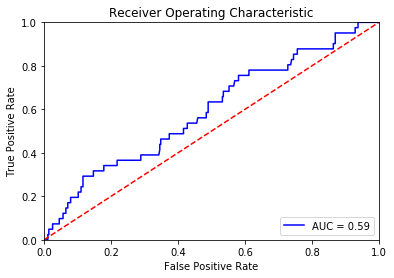

In [30]:
########################################
#print out binary class roc auc figure
############################################
fpr, tpr, threshold = metrics.roc_curve(y,y_xgb_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
##########################
#########################

In [32]:
########################################
#print out multiclass roc auc figure
############################################
#from sklearn.model_selection import cross_val_predict
#from sklearn.metrics import confusion_matrix

#cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed)
#y_xgb_prob = cross_val_predict(xgb, X, y, cv = cv, method = 'predict_proba')

#import matplotlib.pyplot as plt
#plt.figure(figsize = (10, 8))
#plot_multiclass_roc_auc(y, y_xgb_prob, n_classes = 3, title = "xgb, SARC_high_var_0.2, 4 layers")
#plt.savefig('(0606)3class_roc_auc_xgb(4layers12k_0.1test)(SARC_high_var_0.2).png')

## Print out results for a given random seed

In [37]:
print(xgb)
print("Auroc across all folds: %0.5f" % (xgb_multiclass_auroc))
print("Random seed is: ", r_seed)
print("The confusion martix is:\n", xgb_conf_mat)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=12,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.1)
Auroc across all folds: 0.59407
Random seed is:  42
The confusion martix is:
 [[340  13]
 [ 38   3]]


In [ ]:
##############################